In [1]:
# loading libraries
from keras import Input, layers, models, optimizers, regularizers
from keras.initializers import glorot_uniform
from keras.layers import Activation, Add, AveragePooling2D, BatchNormalization, Conv2D, Dense, Flatten, GlobalAveragePooling2D, Input, MaxPooling2D, ZeroPadding2D
from keras.utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import collections
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
import tensorflow as tf

%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")

데이터 불러오기

In [2]:
df=pd.read_pickle("C:\mango\LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [3]:
df = df.drop(['waferIndex'], axis = 1)

In [4]:
#wafer map dimension initialize
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)

In [5]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df = df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [6]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]

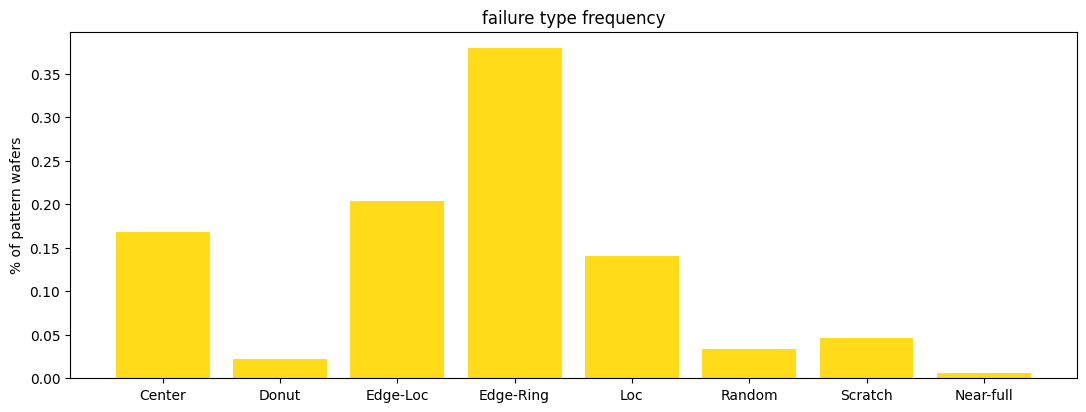

In [7]:
from matplotlib import gridspec

fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 

ax2 = plt.subplot(gs[1])

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='gold', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

웨이퍼 해상도 26 x 26 label로 웨이퍼 및 배열 (일부 웨이퍼 label은 null 생략)

In [8]:
sub_df = df.loc[df['waferMapDim'] == (25, 27)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 25, 27))
label = list()

for i in range(len(sub_df)):
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 25, 27)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [9]:
x1 = sw[1:]
# 27 x 27 사이즈로 맞추기 위한 padding 처리
x = np.pad(x1, ((0,0),(1,1),(0,0)), mode='constant', constant_values = (0,0))
y = np.array(label).reshape((-1,1))

In [10]:
sub_df1 = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer1 = sub_df1['waferMap'].values

sw1 = np.ones((1, 26, 26))
label1 = list()

for i in range(len(sub_df1)):
    if len(sub_df1.iloc[i,:]['failureType']) == 0:
        continue
    sw1 = np.concatenate((sw1, sub_df1.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label1.append(sub_df1.iloc[i,:]['failureType'][0][0])

In [11]:
x2 = sw1[1:]
x3 = np.pad(x2, ((0,0),(1,0),(1,0)), mode='constant', constant_values = (0,0))
y2 = np.array(label1).reshape((-1,1))

In [12]:
sub_df2 = df.loc[df['waferMapDim'] == (27, 25)]
sub_wafer2 = sub_df2['waferMap'].values

sw2 = np.ones((1, 27, 25))
label2= list()

for i in range(len(sub_df2)):
    if len(sub_df2.iloc[i,:]['failureType']) == 0:
        continue
    sw2 = np.concatenate((sw2, sub_df2.iloc[i,:]['waferMap'].reshape(1, 27, 25)))
    label2.append(sub_df2.iloc[i,:]['failureType'][0][0])

In [13]:
x4 = sw2[1:]
x5 = np.pad(x4, ((0,0),(0,0),(1,1)), mode='constant', constant_values = (0,0))
y3 = np.array(label2).reshape((-1,1))

In [14]:
x3 = np.concatenate((x3, x5[0:]))
y2 = np.concatenate((y2, y3))

In [15]:
x = np.concatenate((x, x3[0:]))
y = np.concatenate((y, y2))

In [16]:
faulty_case = np.unique(y)

In [17]:
# '감지되지 않는' none 불량 라벨 제거
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=25000, replace=False)]
new_x = np.delete(x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [18]:
#train과 test 데이터를 8:2 비율로 맞춤
x_train_temp, x_test, y_train_temp, y_test = train_test_split(new_x, new_y, test_size=0.2, random_state=789)

In [19]:
#x_test : 채널 추가
x_test = x_test.reshape((-1, 27, 27, 1))

One-hot-Encoding

In [20]:
# One-hot-Encoding 
nx_test = np.zeros((len(x_test), 27, 27, 3))

for w in range(len(x_test)):
    for i in range(27):
        for j in range(27):
            nx_test[w, i, j, int(x_test[w, i, j])] = 1

In [21]:
#y_test : 문자열 데이터를 정수형으로 형변환
for i, l in enumerate(faulty_case):
    y_test[y_test==l] = i
    
# one-hot-encoding - 10진 정수 형식을 2진 바이너리 형식으로 변경
y_test = to_categorical(y_test)

In [22]:
# One-hot-Encoding
nx_train = np.zeros((len(x_train_temp), 27, 27, 3))

for w in range(len(x_train_temp)):
    for i in range(27):
        for j in range(27):
            nx_train[w, i, j, int(x_train_temp[w, i, j])] = 1

Convolutional AutoEncoder

In [23]:
sx_train = np.delete(nx_train,(0,0,0,0), 1)

In [24]:
sx_train = np.delete(sx_train,(0,0,0,0), 2)

In [25]:
epoch = 50
batch_size=500

In [26]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D(padding='same')(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# decoder layers 연결
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

AutoEncoder = models.Model(input_tensor, output_tensor(decode))
AutoEncoder.compile(optimizer = 'Adam',
              loss = 'mse',
             ) 

In [27]:
AutoEncoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 26, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 13, 13, 64)       36928     
 nspose)                                                         
                                                                 
 up_sampling2d (UpSampling2D  (None, 26, 26, 64)       0         
 )                                                               
                                                             

In [28]:
with tf.device('/GPU:0'):
    AutoEncoder.fit(sx_train, sx_train, batch_size=batch_size, epochs=epoch, verbose=2)

Epoch 1/50
31/31 - 8s - loss: 0.1172 - 8s/epoch - 259ms/step
Epoch 2/50
31/31 - 1s - loss: 0.0733 - 501ms/epoch - 16ms/step
Epoch 3/50
31/31 - 1s - loss: 0.0582 - 578ms/epoch - 19ms/step
Epoch 4/50
31/31 - 1s - loss: 0.0473 - 553ms/epoch - 18ms/step
Epoch 5/50
31/31 - 1s - loss: 0.0375 - 503ms/epoch - 16ms/step
Epoch 6/50
31/31 - 1s - loss: 0.0306 - 508ms/epoch - 16ms/step
Epoch 7/50
31/31 - 1s - loss: 0.0260 - 513ms/epoch - 17ms/step
Epoch 8/50
31/31 - 0s - loss: 0.0226 - 487ms/epoch - 16ms/step
Epoch 9/50
31/31 - 0s - loss: 0.0199 - 483ms/epoch - 16ms/step
Epoch 10/50
31/31 - 1s - loss: 0.0177 - 514ms/epoch - 17ms/step
Epoch 11/50
31/31 - 0s - loss: 0.0159 - 483ms/epoch - 16ms/step
Epoch 12/50
31/31 - 0s - loss: 0.0144 - 480ms/epoch - 15ms/step
Epoch 13/50
31/31 - 0s - loss: 0.0130 - 482ms/epoch - 16ms/step
Epoch 14/50
31/31 - 0s - loss: 0.0119 - 484ms/epoch - 16ms/step
Epoch 15/50
31/31 - 0s - loss: 0.0109 - 488ms/epoch - 16ms/step
Epoch 16/50
31/31 - 0s - loss: 0.0100 - 485ms/epoch

In [29]:
encoder = models.Model(input_tensor, latent_vector)

In [30]:
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [31]:
encoded_x = encoder.predict(sx_train)

471/471 [==============================] - 1s 1ms/step


In [32]:
sy_train_temp = np.array(y_train_temp)

In [33]:
# 웨이퍼 데이터 증강 수행
def gen_data(wafer, label):
    encoded_x = encoder.predict(wafer)
    
    # 노이즈 웨이퍼 수집 배열
    genn_x = np.zeros((1, 26, 26, 3))
    
    # 10000개의 증강 데이터 생성
    for i in range((10000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        genn_x = np.concatenate((genn_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(genn_x), 1), label)
    
    return genn_x[1:], gen_y[1:]

In [34]:
# 훈련 데이터셋 증강
for f in faulty_case : 
    if f == 'none': 
        continue
    genn_x, genn_y = gen_data(sx_train[np.where(y_train_temp==f)[0]], f)
    sx_train = np.concatenate((sx_train, genn_x), axis=0)
    sy_train_temp = np.concatenate((sy_train_temp, genn_y))

3/3 [==============================] - 0s 2ms/step


In [35]:
nsx_train = np.pad(sx_train, ((0,0),(1,0),(1,0),(0,0)), mode='constant', constant_values = (0,0))

In [36]:
for i, l in enumerate(faulty_case):
    sy_train_temp[sy_train_temp==l] = i
    
# one-hot-encoding
y_train = to_categorical(sy_train_temp)

In [37]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
   
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
            
    # AI 모델 평가를 위한 지표를 제공하는 scikit-learn의 metrics
    cm = confusion_matrix(y_true, y_pred)
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [38]:
def GAP_create_model():
    input_shape = (27, 27, 3)
    input_tensor = Input(input_shape)
    
    #initializer: glorot_normal, glorot_uniform, he_normal, he_uniform

    conv_1 = layers.Conv2D(32, (3,3), kernel_initializer='he_normal', activation='relu',padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu',padding='same')(conv_1)

    pool_1 = layers.MaxPool2D((2,2), name = 'max_pool1')(conv_2)

    conv_3 = layers.Conv2D(128, (3,3), kernel_initializer='he_normal',activation='relu', padding='same')(pool_1)
    conv_4 = layers.Conv2D(256, (3,3), kernel_initializer='he_normal',activation='relu', padding='same')(conv_3)

    pool_2 = layers.GlobalAveragePooling2D()(conv_4) #GAP layer

    dense_1 = layers.Dense(512, activation='relu')(pool_2)
    drop_1 = layers.Dropout(0.1)(dense_1)
    dense_2 = layers.Dense(256, activation='relu')(drop_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
 
    return model

In [39]:
W_model = GAP_create_model()

In [40]:
W_model.compile(optimizer= optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
W_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 27, 27, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        896       
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pool1 (MaxPooling2D)    (None, 13, 13, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 global_average_pooling2d (G  (None, 256)              0   

In [42]:
with tf.device('/GPU:0'):    
    Hist = W_model.fit(nsx_train, y_train, epochs=50, validation_data=[nx_test, y_test], batch_size=900, shuffle=True)

Epoch 1/50
109/109 [==============================] - 12s 83ms/step - loss: 1.1607 - accuracy: 0.5473 - val_loss: 0.3228 - val_accuracy: 0.9278
Epoch 2/50
109/109 [==============================] - 8s 69ms/step - loss: 0.4252 - accuracy: 0.8417 - val_loss: 0.2601 - val_accuracy: 0.9233
Epoch 3/50
109/109 [==============================] - 8s 69ms/step - loss: 0.2482 - accuracy: 0.9108 - val_loss: 0.1389 - val_accuracy: 0.9562
Epoch 4/50
109/109 [==============================] - 8s 69ms/step - loss: 0.1896 - accuracy: 0.9329 - val_loss: 0.1441 - val_accuracy: 0.9530
Epoch 5/50
109/109 [==============================] - 8s 69ms/step - loss: 0.1161 - accuracy: 0.9613 - val_loss: 0.1432 - val_accuracy: 0.9519
Epoch 6/50
109/109 [==============================] - 8s 70ms/step - loss: 0.0937 - accuracy: 0.9689 - val_loss: 0.1590 - val_accuracy: 0.9490
Epoch 7/50
109/109 [==============================] - 8s 70ms/step - loss: 0.0649 - accuracy: 0.9781 - val_loss: 0.1551 - val_accuracy: 0.947

In [43]:
### START CODE HERE ### (1 line)
epred = W_model.evaluate(x = nx_test, y = y_test)
### END CODE HERE ###
print()
print ("Loss = " + str(epred[0]))
print ("Test Accuracy = " + str(epred[1]))

118/118 [==============================] - 1s 4ms/step - loss: 0.1484 - accuracy: 0.9711

Loss = 0.14841130375862122
Test Accuracy = 0.9710568189620972


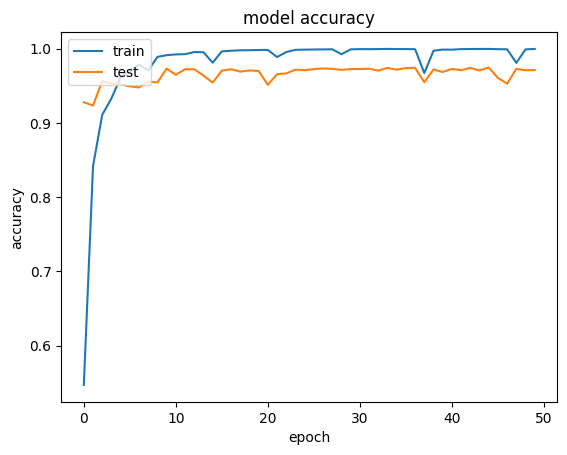

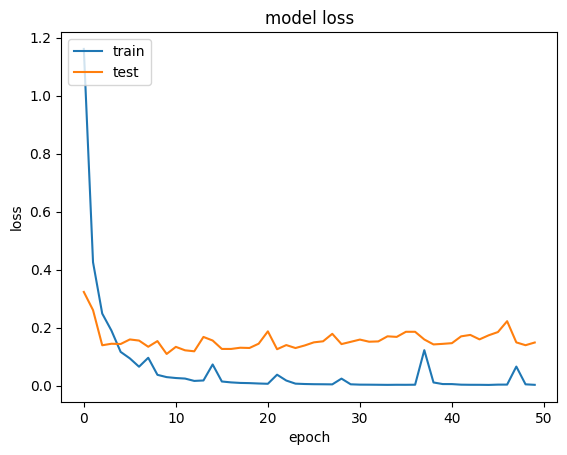

In [44]:
# accuracy plot 
plt.plot(Hist.history['accuracy'])
plt.plot(Hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(Hist.history['loss'])
plt.plot(Hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
y_pred = W_model.predict(nx_test)

118/118 [==============================] - 1s 2ms/step


In [46]:
y_test_decode = np.ones(len(y_test))
y_pred_decode = np.ones(len(y_pred))

for i in range(len(y_pred)):
    y_pred_decode[i] = np.argmax(y_pred[i])
    y_test_decode[i] = np.argmax(y_test[i])

In [47]:
mis_index = np.where(y_pred_decode != y_test_decode)

In [48]:
print(classification_report(y_test_decode, y_pred_decode, target_names=faulty_case))

              precision    recall  f1-score   support

      Center       0.98      0.98      0.98       462
       Donut       1.00      1.00      1.00         1
    Edge-Loc       0.84      0.84      0.84       161
   Edge-Ring       1.00      0.56      0.71         9
         Loc       0.73      0.67      0.70        99
   Near-full       0.92      1.00      0.96        11
      Random       0.86      0.97      0.91        33
     Scratch       0.72      0.65      0.68        20
        none       0.99      0.99      0.99      2970

    accuracy                           0.97      3766
   macro avg       0.89      0.85      0.86      3766
weighted avg       0.97      0.97      0.97      3766



Confusion matrix, without normalization
[[ 454    0    1    0    4    0    0    0    3]
 [   0    1    0    0    0    0    0    0    0]
 [   0    0  136    0    2    0    2    1   20]
 [   0    0    3    5    0    0    0    0    1]
 [   4    0   12    0   66    0    3    1   13]
 [   0    0    0    0    0   11    0    0    0]
 [   0    0    0    0    0    1   32    0    0]
 [   0    0    0    0    2    0    0   13    5]
 [   3    0    9    0   16    0    0    3 2939]]
Normalized confusion matrix
[[0.98 0.   0.   0.   0.01 0.   0.   0.   0.01]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.84 0.   0.01 0.   0.01 0.01 0.12]
 [0.   0.   0.33 0.56 0.   0.   0.   0.   0.11]
 [0.04 0.   0.12 0.   0.67 0.   0.03 0.01 0.13]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.03 0.97 0.   0.  ]
 [0.   0.   0.   0.   0.1  0.   0.   0.65 0.25]
 [0.   0.   0.   0.   0.01 0.   0.   0.   0.99]]


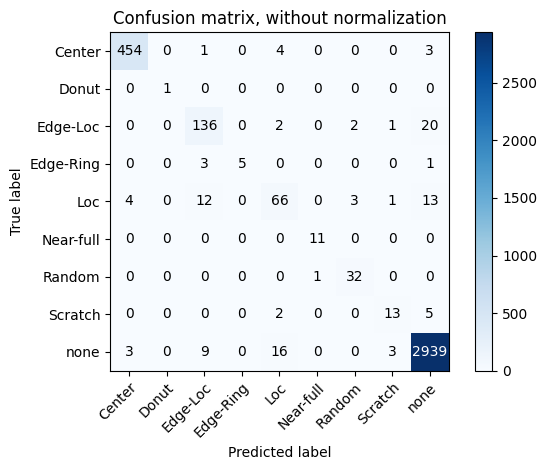

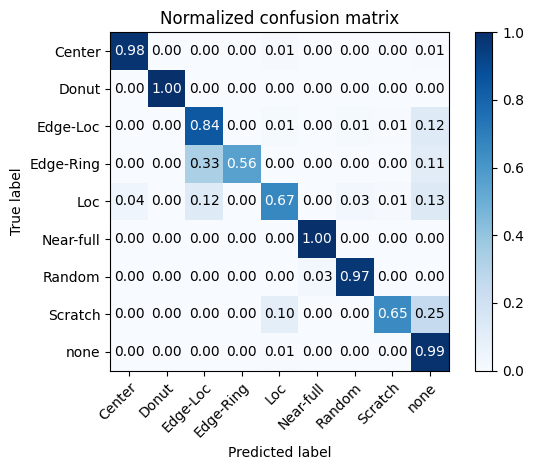

In [49]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_decode, y_pred_decode, classes=faulty_case, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_decode, y_pred_decode, classes=faulty_case, normalize=True, title='Normalized confusion matrix')

plt.show()

In [50]:
def VGG16(include_top=True,  pooling=None, classes=9):
    
    input_shape = (27, 27, 3)
    input_tensor = Input(input_shape)
    
    # Block 1
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(input_tensor)
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), name='block1_pool')(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), name='block2_pool')(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')(x)
    x = layers.MaxPooling2D((2, 2), name='block3_pool')(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(x)
    x = layers.MaxPooling2D((2, 2), name='block4_pool')(x)

    if include_top:
        # Classification block
        x = layers.Flatten(name='flatten')(x)
        x = layers.Dense(1028, activation='relu', name='fc1')(x)
        x = layers.Dense(1028, activation='relu', name='fc2')(x)
        x = layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Create model
    model = models.Model(input_tensor, x, name='vgg16') 

    return model

In [51]:
VGG_model = VGG16(include_top=True, pooling=None, classes=9)

In [52]:
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 27, 27, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 27, 27, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 27, 27, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 13, 13, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 13, 13, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 13, 13, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 6, 6, 128)         0     

In [53]:
VGG_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [54]:
with tf.device('/GPU:0'):
    VGG_model_fit = VGG_model.fit(nsx_train, y_train, epochs=50, validation_data=[nx_test, y_test], batch_size=900, shuffle=True)

Epoch 1/50
109/109 [==============================] - 26s 178ms/step - loss: 1.6418 - accuracy: 0.3292 - val_loss: 0.6005 - val_accuracy: 0.8680
Epoch 2/50
109/109 [==============================] - 16s 145ms/step - loss: 0.2866 - accuracy: 0.8957 - val_loss: 0.2656 - val_accuracy: 0.9243
Epoch 3/50
109/109 [==============================] - 16s 145ms/step - loss: 0.0547 - accuracy: 0.9841 - val_loss: 0.2554 - val_accuracy: 0.9392
Epoch 4/50
109/109 [==============================] - 16s 145ms/step - loss: 0.0245 - accuracy: 0.9929 - val_loss: 0.2338 - val_accuracy: 0.9559
Epoch 5/50
109/109 [==============================] - 16s 145ms/step - loss: 0.0175 - accuracy: 0.9954 - val_loss: 0.2948 - val_accuracy: 0.9379
Epoch 6/50
109/109 [==============================] - 16s 146ms/step - loss: 0.0115 - accuracy: 0.9965 - val_loss: 0.1920 - val_accuracy: 0.9628
Epoch 7/50
109/109 [==============================] - 16s 146ms/step - loss: 0.0075 - accuracy: 0.9981 - val_loss: 0.2094 - val_ac

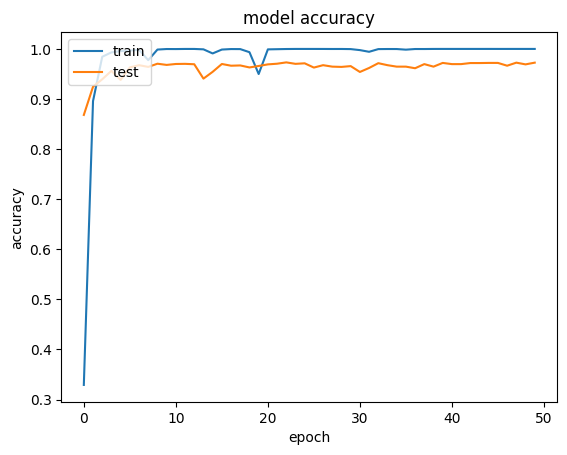

In [55]:
# accuracy plot 
plt.plot(VGG_model_fit.history['accuracy'])
plt.plot(VGG_model_fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

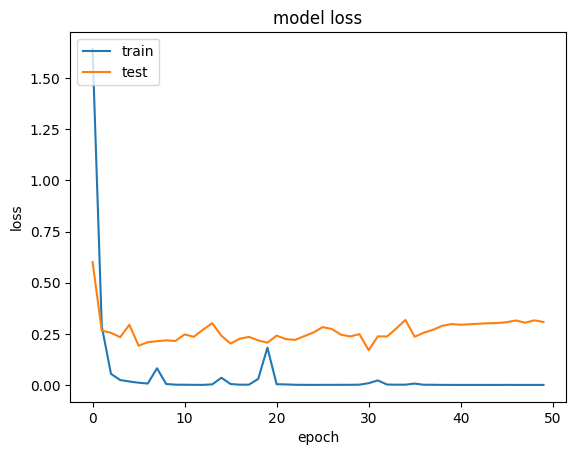

In [56]:
# loss plot
plt.plot(VGG_model_fit.history['loss'])
plt.plot(VGG_model_fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [57]:
vy_pred = VGG_model.predict(nx_test)

118/118 [==============================] - 1s 5ms/step


In [58]:
vy_test_decode = np.ones(len(y_test))
vy_pred_decode = np.ones(len(vy_pred))

for i in range(len(vy_pred)):
    vy_pred_decode[i] = np.argmax(vy_pred[i])
    vy_test_decode[i] = np.argmax(y_test[i])

In [59]:
vmis_index = np.where(vy_pred_decode != vy_test_decode)

In [60]:
print(classification_report(vy_test_decode, vy_pred_decode, target_names=faulty_case))

              precision    recall  f1-score   support

      Center       0.99      0.98      0.99       462
       Donut       1.00      1.00      1.00         1
    Edge-Loc       0.88      0.85      0.86       161
   Edge-Ring       1.00      0.56      0.71         9
         Loc       0.74      0.71      0.72        99
   Near-full       0.92      1.00      0.96        11
      Random       0.88      0.91      0.90        33
     Scratch       1.00      0.40      0.57        20
        none       0.98      0.99      0.99      2970

    accuracy                           0.97      3766
   macro avg       0.93      0.82      0.86      3766
weighted avg       0.97      0.97      0.97      3766



Confusion matrix, without normalization
[[ 455    0    0    0    2    0    0    0    5]
 [   0    1    0    0    0    0    0    0    0]
 [   0    0  137    0    9    0    2    0   13]
 [   0    0    3    5    0    0    0    0    1]
 [   0    0    6    0   70    0    2    0   21]
 [   0    0    0    0    0   11    0    0    0]
 [   0    0    0    0    1    1   30    0    1]
 [   0    0    1    0    1    0    0    8   10]
 [   4    0    9    0   12    0    0    0 2945]]
Normalized confusion matrix
[[0.98 0.   0.   0.   0.   0.   0.   0.   0.01]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.85 0.   0.06 0.   0.01 0.   0.08]
 [0.   0.   0.33 0.56 0.   0.   0.   0.   0.11]
 [0.   0.   0.06 0.   0.71 0.   0.02 0.   0.21]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.03 0.03 0.91 0.   0.03]
 [0.   0.   0.05 0.   0.05 0.   0.   0.4  0.5 ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.99]]


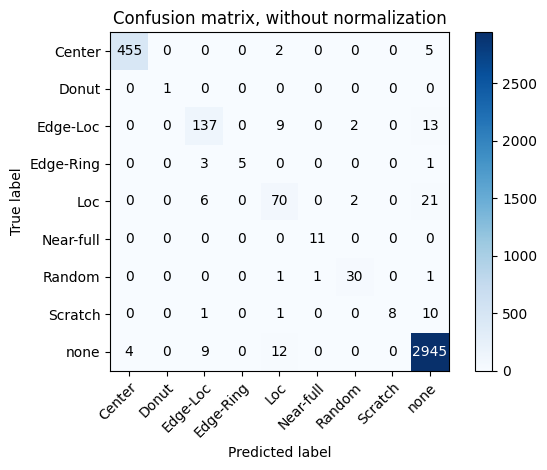

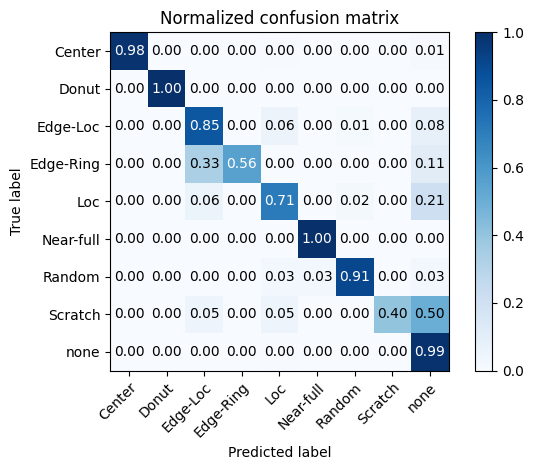

In [61]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(vy_test_decode, vy_pred_decode, classes=faulty_case, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(vy_test_decode, vy_pred_decode, classes=faulty_case, normalize=True, title='Normalized confusion matrix')

plt.show()

In [62]:
def identity_block(X, f, filters, stage, block):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [63]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X


    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [64]:
def ResNet50(input_shape = (27, 27, 3), classes = 9):
    
    # input_shpae 27 x 27 x 3
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((1, 1))(X_input)
    
    # ResidualBlock 1
    X = Conv2D(64, (3, 3), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2))(X)

    # ResidualBlock 2 (≈3 layers)
    X = convolutional_block(X, f = 3, filters = [32,32,128], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [32,32,128], stage=2, block='b')
    X = identity_block(X, 3, [32,32,128], stage=2, block='c')
    
    # ResidualBlock 3 (≈4 layers)
    X = convolutional_block(X, f = 3, filters = [64,64,256], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [64,64,256], stage=3, block='b')
    X = identity_block(X, 3, [64,64,256], stage=3, block='c')
    X = identity_block(X, 3, [64,64,256], stage=3, block='d')

    # ResidualBlock 4 (≈6 layers)
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=4, block='b')
    X = identity_block(X, 3, [128,128,512], stage=4, block='c')
    X = identity_block(X, 3, [128,128,512], stage=4, block='d')
    X = identity_block(X, 3, [128,128,512], stage=4, block='e')
    X = identity_block(X, 3, [128,128,512], stage=4, block='f')

    # ResidualBlock 5 (≈3 layers)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), name = "avg_pool")(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = models.Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [65]:
Rmodel = ResNet50(input_shape = (27, 27, 3), classes = 9)

In [66]:
Rmodel.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 27, 27, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 29, 29, 3)   0           ['input_5[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 27, 27, 64)   1792        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 27, 27, 64)   256         ['conv1[0][0]']                  
                                                                                           

In [67]:
Rmodel.compile(optimizer= optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [69]:
with tf.device('/GPU:0'):
    Resnet_fit = Rmodel.fit(nsx_train, y_train, epochs=30, validation_data=[nx_test, y_test], batch_size = 700, shuffle=True)

Epoch 1/30
140/140 [==============================] - 26s 185ms/step - loss: 0.0918 - accuracy: 0.9678 - val_loss: 1.5617 - val_accuracy: 0.7693
Epoch 2/30
140/140 [==============================] - 23s 164ms/step - loss: 0.0201 - accuracy: 0.9940 - val_loss: 7.6014 - val_accuracy: 0.0467
Epoch 3/30
140/140 [==============================] - 23s 166ms/step - loss: 0.0099 - accuracy: 0.9970 - val_loss: 2.6096 - val_accuracy: 0.4878
Epoch 4/30
140/140 [==============================] - 22s 160ms/step - loss: 0.0129 - accuracy: 0.9959 - val_loss: 0.4263 - val_accuracy: 0.9230
Epoch 5/30
140/140 [==============================] - 23s 165ms/step - loss: 0.0085 - accuracy: 0.9974 - val_loss: 0.4055 - val_accuracy: 0.9557
Epoch 6/30
140/140 [==============================] - 23s 162ms/step - loss: 0.0083 - accuracy: 0.9976 - val_loss: 0.3440 - val_accuracy: 0.9472
Epoch 7/30
140/140 [==============================] - 22s 159ms/step - loss: 0.0060 - accuracy: 0.9980 - val_loss: 0.4211 - val_ac

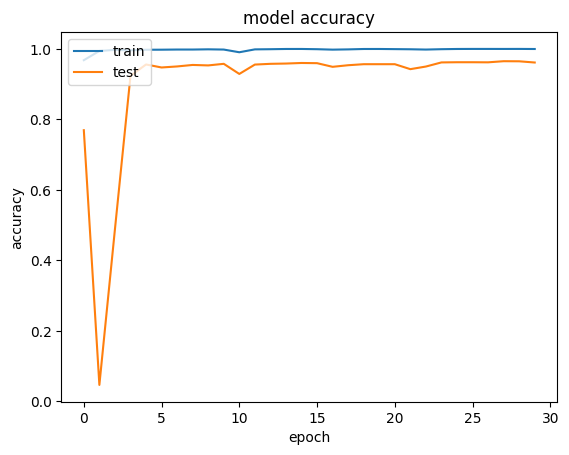

In [70]:
# accuracy plot 
plt.plot(Resnet_fit.history['accuracy'])
plt.plot(Resnet_fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

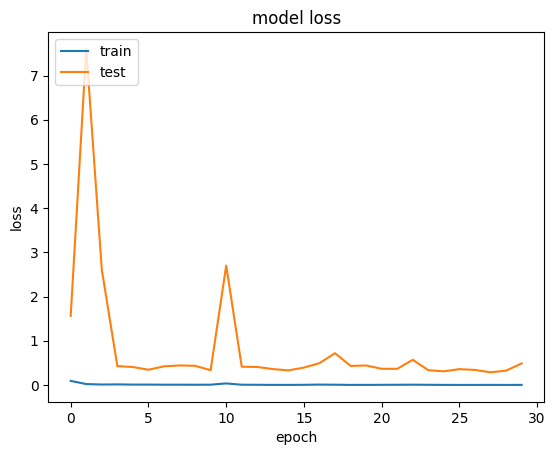

In [71]:
# loss plot
plt.plot(Resnet_fit.history['loss'])
plt.plot(Resnet_fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [72]:
resy_pred = Rmodel.predict(nx_test)

118/118 [==============================] - 3s 13ms/step


In [73]:
resy_test_decode = np.ones(len(y_test))
resy_pred_decode = np.ones(len(resy_pred))

for i in range(len(resy_pred)):
    resy_pred_decode[i] = np.argmax(resy_pred[i])
    resy_test_decode[i] = np.argmax(y_test[i])

In [74]:
resmis_index = np.where(resy_pred_decode != resy_test_decode)

In [75]:
print(classification_report(resy_test_decode, resy_pred_decode, target_names=faulty_case))

              precision    recall  f1-score   support

      Center       0.98      0.98      0.98       462
       Donut       0.00      0.00      0.00         1
    Edge-Loc       0.87      0.73      0.79       161
   Edge-Ring       1.00      0.44      0.62         9
         Loc       0.78      0.39      0.52        99
   Near-full       1.00      0.64      0.78        11
      Random       0.72      0.94      0.82        33
     Scratch       1.00      0.25      0.40        20
        none       0.97      1.00      0.98      2970

    accuracy                           0.96      3766
   macro avg       0.81      0.60      0.65      3766
weighted avg       0.96      0.96      0.96      3766



Confusion matrix, without normalization
[[ 451    0    0    0    1    0    0    0   10]
 [   0    0    0    0    1    0    0    0    0]
 [   1    0  118    0    5    0    4    0   33]
 [   0    0    3    4    0    0    0    0    2]
 [   5    0   11    0   39    0    4    0   40]
 [   0    0    0    0    0    7    4    0    0]
 [   0    0    0    0    1    0   31    0    1]
 [   1    0    1    0    1    0    0    5   12]
 [   0    0    3    0    2    0    0    0 2965]]
Normalized confusion matrix
[[9.76e-01 0.00e+00 0.00e+00 0.00e+00 2.16e-03 0.00e+00 0.00e+00 0.00e+00
  2.16e-02]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00]
 [6.21e-03 0.00e+00 7.33e-01 0.00e+00 3.11e-02 0.00e+00 2.48e-02 0.00e+00
  2.05e-01]
 [0.00e+00 0.00e+00 3.33e-01 4.44e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  2.22e-01]
 [5.05e-02 0.00e+00 1.11e-01 0.00e+00 3.94e-01 0.00e+00 4.04e-02 0.00e+00
  4.04e-01]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 6.36e-01 3.64e-01 0.00

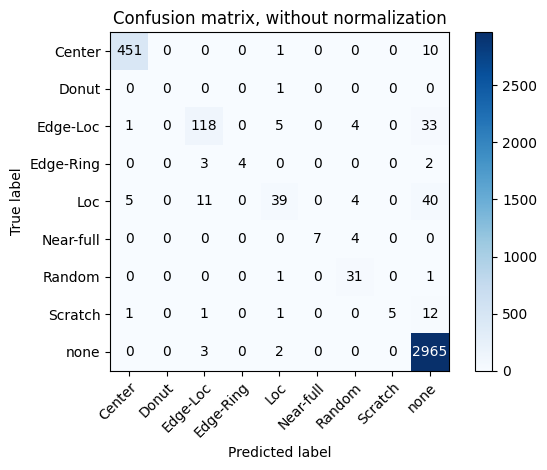

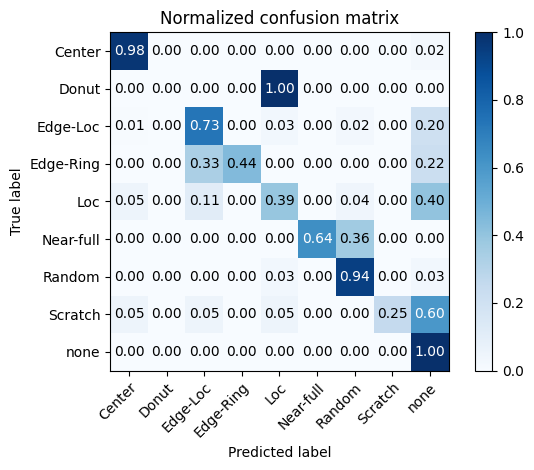

In [76]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(resy_test_decode, resy_pred_decode, classes=faulty_case, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(resy_test_decode, resy_pred_decode, classes=faulty_case, normalize=True, title='Normalized confusion matrix')

plt.show()

In [77]:
BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'strides', 'se_ratio'
])

DEFAULT_BLOCKS_ARGS = [
    BlockArgs(3, 1, 32, 16, 1, [1, 1], 0.25),
    BlockArgs(3, 2, 16, 24, 6, [2, 2], 0.25),
    BlockArgs(5, 2, 24, 40, 6, [2, 2], 0.25),
    BlockArgs(3, 3, 40, 80, 6, [2, 2], 0.25),
    BlockArgs(5, 3, 80, 112,6, [1, 1], 0.25),
    BlockArgs(5, 4, 112, 192, 6, [2, 2], 0.25),
    BlockArgs(3, 1, 192, 320, 6, [1, 1], 0.25)
]

CONV_KERNEL_INITIALIZER = glorot_uniform(seed=0)

BN_AXIS = 3

In [78]:
def get_swish():
    def swish(x):
        return x * tf.nn.sigmoid(x)
    return swish

In [79]:
def get_dropout():
    """Wrapper over custom dropout. Fix problem of ``None`` shape for tf.keras.
    It is not possible to define FixedDropout class as global object,
    because we do not have modules for inheritance at first time.

    Issue:
        https://github.com/tensorflow/tensorflow/issues/30946
    """

    class FixedDropout(layers.Dropout):
        def _get_noise_shape(self, inputs):
            if self.noise_shape is None:
                return self.noise_shape

            symbolic_shape = tf.shape(inputs)
            noise_shape = [symbolic_shape[axis] if shape is None else shape
                           for axis, shape in enumerate(self.noise_shape)]
            return tuple(noise_shape)

    return FixedDropout

In [80]:
def round_filters(filters, width_coefficient, depth_divisor):
    """Round number of filters based on width multiplier."""

    filters *= width_coefficient
    new_filters = int(filters + depth_divisor / 2) // depth_divisor * depth_divisor
    new_filters = max(depth_divisor, new_filters)
    
    # 원래 값이 x라면, 반올림후 값(y)은 x의 0.9 이상이어야 함
    if new_filters < 0.9 * filters:
        new_filters += depth_divisor
    return int(new_filters)

In [81]:
def round_repeats(repeats, depth_coefficient):
    """Round number of repeats based on depth multiplier."""
    return int(math.ceil(depth_coefficient * repeats))

In [82]:
def MBConvBlock(inputs, block_args, activation, drop_rate=None, prefix='', ):
    """
    Mobile Inverted Residual Bottleneck Block
    """
    
    # noise_shape에 none이 있으면 작동하지 않을 경우의 대비책
    Dropout = get_dropout()
    
    has_se = (block_args.se_ratio is not None) and (0 < block_args.se_ratio <= 1)
    x = inputs
    
    # Expansion phase
    output = block_args.input_filters * block_args.expand_ratio
    if block_args.expand_ratio != 1:
        x = layers.Conv2D(output, 1,
                          padding='same',
                          use_bias=False, 
                          kernel_initializer=CONV_KERNEL_INITIALIZER,
                          name=prefix + 'expand_conv')(x)
        x = layers.BatchNormalization(axis=BN_AXIS, name=prefix + 'expand_bn')(x)
        x = layers.Activation(activation, name=prefix + 'expand_activation')(x)
    
    # Depthwise convolution phase 
    x = layers.DepthwiseConv2D(block_args.kernel_size, 
                               strides=block_args.strides, 
                               padding='same',
                               use_bias=False, 
                               depthwise_initializer=CONV_KERNEL_INITIALIZER,
                               name=prefix + 'conv')(x)
    x = layers.BatchNormalization(axis=BN_AXIS, name=prefix + 'bn')(x)
    x = layers.Activation(activation, name=prefix + 'activation')(x)
   
    # Squeeze and Excitation layer, if desired
    if has_se:
        num_sqeezed_channels = max(1, int(block_args.input_filters * block_args.se_ratio))
        
        se_tensor = layers.GlobalAveragePooling2D()(x)
        se_tensor = layers.Reshape((1,1,output), name=prefix + 'se_reshape')(se_tensor)
        se_tensor = layers.Conv2D(num_sqeezed_channels, 1, 
                          activation=activation, 
                          padding='same',
                          kernel_initializer=CONV_KERNEL_INITIALIZER,
                          name=prefix + 'se_reduce')(se_tensor)
        se_tensor = layers.Conv2D(output, 1, 
                          activation='sigmoid', 
                          padding='same',
                          kernel_initializer=CONV_KERNEL_INITIALIZER,
                          name=prefix + 'se_expand')(se_tensor)
        x = layers.multiply([x, se_tensor], name=prefix + 'se_excite')
    
    #Output phase
    x = layers.Conv2D(block_args.output_filters, 1,
                      padding='same',
                      use_bias=False, 
                      kernel_initializer=CONV_KERNEL_INITIALIZER,
                      name=prefix + 'project_conv')(x)
    x = layers.BatchNormalization(axis=BN_AXIS, name=prefix + 'project_bn')(x)
    if all(s == 1 for s in block_args.strides) and block_args.input_filters == block_args.output_filters:
        if drop_rate and (drop_rate > 0):
            x = Dropout(drop_rate,
                        noise_shape=(None, 1, 1, 1),
                        name=prefix + 'drop')(x)
        x = layers.add([x, inputs], name=prefix + 'add')
    
    return x

In [83]:
def EfficientNet(width_coefficient,
                 depth_coefficient,
                 drop_connect_rate, 
                 input_shape,
                 classes,
                 dropout_rate=0.2,
                 depth_divisor=8,
                 blocks_args=DEFAULT_BLOCKS_ARGS,
                 model_name='efficientnet'):
    
    input_tensor = layers.Input(input_shape)
    activation = get_swish()
    
    # Stem
    x = input_tensor
    x = layers.Conv2D(round_filters(32, width_coefficient, depth_divisor), 3,
                      strides=(2,2), 
                      padding='same',
                      use_bias=False, 
                      kernel_initializer=CONV_KERNEL_INITIALIZER,
                      name='stem_conv')(x)
    x = layers.BatchNormalization(axis=BN_AXIS, name='stem_bn')(x)
    x = layers.Activation(activation, name='stem_activation')(x)
    
    # Build blocks
    num_blocks_total = sum(round_repeats(block_args.num_repeat, depth_coefficient) for block_args in blocks_args)
    block_num = 0
    
    for idx, block_args in enumerate(blocks_args):
        # Update block input and output filters based on depth multiplier.
        block_args = block_args._replace(
            input_filters=round_filters(block_args.input_filters, width_coefficient, depth_divisor),
            output_filters=round_filters(block_args.output_filters, width_coefficient, depth_divisor),
            num_repeat=round_repeats(block_args.num_repeat, depth_coefficient))
        
        # The first block needs to take care of stride and filter size increase.
        drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
        
        x = MBConvBlock(x, block_args,
                        activation=activation, 
                        drop_rate=drop_rate, 
                        prefix='block{}a_'.format(idx + 1))    
        block_num += 1
        
        if block_args.num_repeat > 1:
            block_args = block_args._replace(input_filters=block_args.output_filters, strides=[1, 1])
            for bidx in range(block_args.num_repeat - 1):
                drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
                block_prefix = 'block{}{}_'.format(idx + 1, string.ascii_lowercase[bidx + 1])
                
                x = MBConvBlock(x, block_args,
                                activation=activation, 
                                drop_rate=drop_rate, 
                                prefix=block_prefix)
                block_num += 1
                
    # Build top
    x = layers.Conv2D(round_filters(1280, width_coefficient, depth_divisor), 1,
                      padding='same',
                      use_bias=False, 
                      kernel_initializer=CONV_KERNEL_INITIALIZER,
                      name='top_conv')(x)
    x = layers.BatchNormalization(axis=BN_AXIS, name='top_bn')(x)
    x = layers.Activation(activation, name='top_activation')(x)
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dropout(dropout_rate, name='top_dropout')(x)
    x = layers.Dense(classes, 
                     activation='softmax', 
                     kernel_initializer=CONV_KERNEL_INITIALIZER,
                     name='probs')(x)
    
    # 모델 생성
    model = models.Model(input_tensor, x, name=model_name)
    
    return model

In [84]:
Emodel = EfficientNet(1.0, 1.0, 0.2, input_shape = (27, 27, 3), classes=9, model_name='efficientnet-b0')

In [85]:
Emodel.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 27, 27, 3)]  0           []                               
                                                                                                  
 stem_conv (Conv2D)             (None, 14, 14, 32)   864         ['input_6[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 14, 14, 32)   128         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 14, 14, 32)   0           ['stem_bn[0][0]']                
                                                                                    

In [86]:
Emodel.compile(optimizer= optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [87]:
with tf.device('/GPU:0'):
    Emodel_fit = Emodel.fit(nsx_train, y_train, epochs=10, validation_data=[nx_test, y_test], batch_size = 700, shuffle=True)

Epoch 1/30
140/140 [==============================] - 66s 390ms/step - loss: 0.3222 - accuracy: 0.8844 - val_loss: 2.1669 - val_accuracy: 0.1227
Epoch 2/30
140/140 [==============================] - 51s 363ms/step - loss: 0.0376 - accuracy: 0.9883 - val_loss: 2.1983 - val_accuracy: 0.1227
Epoch 3/30
140/140 [==============================] - 51s 363ms/step - loss: 0.0214 - accuracy: 0.9931 - val_loss: 2.2268 - val_accuracy: 0.0428
Epoch 4/30
140/140 [==============================] - 50s 360ms/step - loss: 0.0165 - accuracy: 0.9949 - val_loss: 1.8694 - val_accuracy: 0.0935
Epoch 5/30
140/140 [==============================] - 50s 357ms/step - loss: 0.0155 - accuracy: 0.9952 - val_loss: 0.2502 - val_accuracy: 0.9365
Epoch 6/30
140/140 [==============================] - 50s 358ms/step - loss: 0.0115 - accuracy: 0.9964 - val_loss: 0.3457 - val_accuracy: 0.9527
Epoch 7/30
140/140 [==============================] - 50s 355ms/step - loss: 0.0082 - accuracy: 0.9975 - val_loss: 0.3864 - val_ac

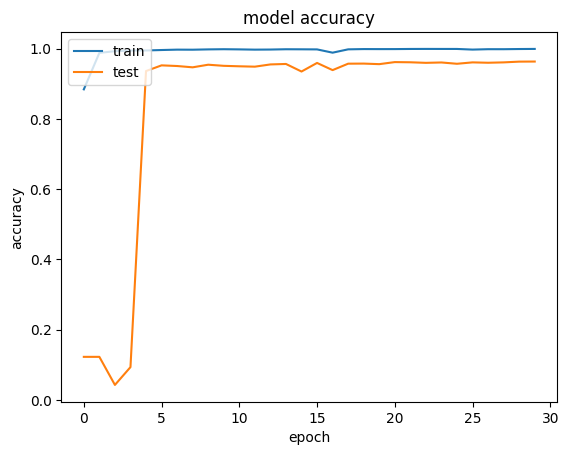

In [88]:
# accuracy plot 
plt.plot(Emodel_fit.history['accuracy'])
plt.plot(Emodel_fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

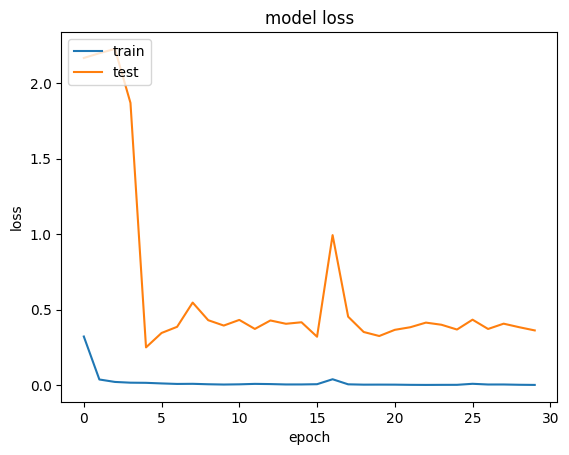

In [89]:
# loss plot
plt.plot(Emodel_fit.history['loss'])
plt.plot(Emodel_fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [90]:
effy_pred = Emodel.predict(nx_test)

118/118 [==============================] - 4s 18ms/step


In [91]:
effy_test_decode = np.ones(len(y_test))
effy_pred_decode = np.ones(len(effy_pred))

for i in range(len(resy_pred)):
    effy_pred_decode[i] = np.argmax(effy_pred[i])
    effy_test_decode[i] = np.argmax(y_test[i])

In [92]:
effmis_index = np.where(effy_pred_decode != effy_test_decode)

In [93]:
print(classification_report(effy_test_decode, effy_pred_decode, target_names=faulty_case))

              precision    recall  f1-score   support

      Center       0.99      0.98      0.99       462
       Donut       0.00      0.00      0.00         1
    Edge-Loc       0.79      0.76      0.78       161
   Edge-Ring       1.00      0.56      0.71         9
         Loc       0.71      0.56      0.62        99
   Near-full       1.00      0.91      0.95        11
      Random       0.96      0.76      0.85        33
     Scratch       0.83      0.25      0.38        20
        none       0.98      0.99      0.98      2970

    accuracy                           0.96      3766
   macro avg       0.81      0.64      0.70      3766
weighted avg       0.96      0.96      0.96      3766



Confusion matrix, without normalization
[[ 455    0    0    0    2    0    0    0    5]
 [   0    0    0    0    1    0    0    0    0]
 [   0    0  123    0    9    0    0    0   29]
 [   0    0    3    5    0    0    0    0    1]
 [   3    0    9    0   55    0    1    0   31]
 [   0    0    1    0    0   10    0    0    0]
 [   0    0    4    0    4    0   25    0    0]
 [   1    0    4    0    2    0    0    5    8]
 [   2    0   11    0    5    0    0    1 2951]]
Normalized confusion matrix
[[9.85e-01 0.00e+00 0.00e+00 0.00e+00 4.33e-03 0.00e+00 0.00e+00 0.00e+00
  1.08e-02]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00]
 [0.00e+00 0.00e+00 7.64e-01 0.00e+00 5.59e-02 0.00e+00 0.00e+00 0.00e+00
  1.80e-01]
 [0.00e+00 0.00e+00 3.33e-01 5.56e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  1.11e-01]
 [3.03e-02 0.00e+00 9.09e-02 0.00e+00 5.56e-01 0.00e+00 1.01e-02 0.00e+00
  3.13e-01]
 [0.00e+00 0.00e+00 9.09e-02 0.00e+00 0.00e+00 9.09e-01 0.00e+00 0.00

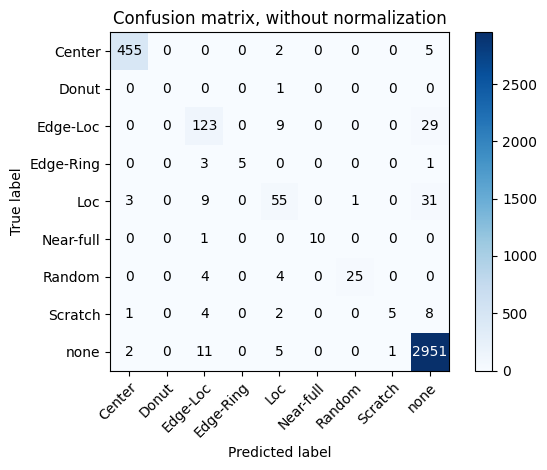

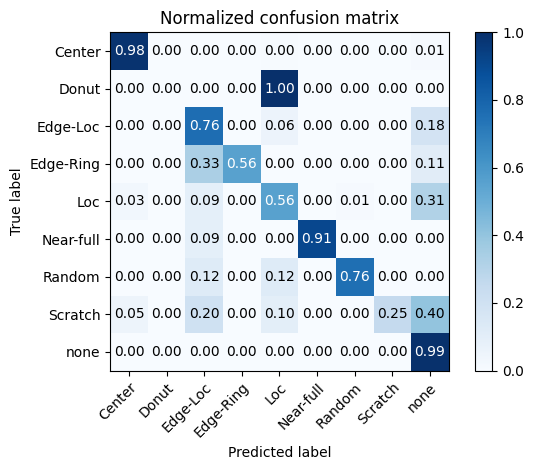

In [94]:
plot_confusion_matrix(effy_test_decode, effy_pred_decode, classes=faulty_case, title='Confusion matrix, without normalization')

plot_confusion_matrix(effy_test_decode, effy_pred_decode, classes=faulty_case, normalize=True, title='Normalized confusion matrix')

plt.show()

In [95]:
last_conv_layer = Rmodel.get_layer("activation_48")

model_1 = models.Model(Rmodel.inputs, last_conv_layer.output)

In [96]:
input_2 = layers.Input(shape=last_conv_layer.output.shape[1:])
x_2 = Rmodel.get_layer("flatten")(input_2)
model_2 = models.Model(input_2, x_2)

In [97]:
with tf.GradientTape() as tape:
    output_1 = model_1(nx_test)
    tape.watch(output_1)
    preds = model_2(output_1)
    class_id = tf.argmax(preds[0])
    output_2 = preds[:,class_id]
    
grads = tape.gradient(output_1, output_1)
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

ResourceExhaustedError: Exception encountered when calling layer "res2a_branch2c" "                 f"(type Conv2D).

{{function_node __wrapped__BiasAdd_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[3766,13,13,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:BiasAdd]

Call arguments received by layer "res2a_branch2c" "                 f"(type Conv2D):
  • inputs=tf.Tensor(shape=(3766, 13, 13, 32), dtype=float32)